In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 设置自动求导异常检测（可选）
torch.autograd.set_detect_anomaly(True)

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 数据准备
def prepare_data():
    # 设置不同的均值
    negative_mean = 0.0
    positive_mean = 2.0  # 正样本均值偏移为2.0，使其与负样本分布明显不同
    
    # 生成1000个128维的负样本和正样本，均值不同，标准差相同
    negative_samples = np.random.randn(1000, 128) + negative_mean
    positive_samples = np.random.randn(1000, 128) + positive_mean
    
    # 转换为PyTorch张量
    negative_samples = torch.from_numpy(negative_samples).float()
    positive_samples = torch.from_numpy(positive_samples).float()
    
    # 划分训练集和验证集
    train_size = 800
    val_size = 200
    train_negative = negative_samples[:train_size]
    train_positive = positive_samples[:train_size]
    val_negative = negative_samples[train_size:train_size+val_size]
    val_positive = positive_samples[train_size:train_size+val_size]
    
    return (train_negative, train_positive), (val_negative, val_positive)

# 创建DataLoader
def create_dataloaders(train_data, val_data, batch_size=32):
    train_negative, train_positive = train_data
    val_negative, val_positive = val_data
    
    # 创建训练集的DataLoader
    train_dataset_neg = TensorDataset(train_negative)
    train_loader_neg = DataLoader(train_dataset_neg, batch_size=batch_size, shuffle=True)
    
    train_dataset_pos = TensorDataset(train_positive)
    train_loader_pos = DataLoader(train_dataset_pos, batch_size=batch_size, shuffle=True)
    
    # 创建验证集的DataLoader
    val_dataset_neg = TensorDataset(val_negative)
    val_loader_neg = DataLoader(val_dataset_neg, batch_size=batch_size, shuffle=False)
    
    val_dataset_pos = TensorDataset(val_positive)
    val_loader_pos = DataLoader(val_dataset_pos, batch_size=batch_size, shuffle=False)
    
    return (train_loader_neg, train_loader_pos), (val_loader_neg, val_loader_pos)

# 定义综合L1损失函数
def combined_l1_loss(generated_neg, generated_pos, target_pos, l1_criterion):
    # L1损失：负样本转换后与正样本的差异
    loss_neg = l1_criterion(generated_neg, target_pos)
    # L1损失：正样本转换后与正样本的差异
    loss_pos = l1_criterion(generated_pos, target_pos)
    # 综合损失，可以根据需要调整权重
    combined_loss = loss_neg + loss_pos
    return combined_loss

# def main():
# 准备数据
train_data, val_data = prepare_data()
(train_loader_neg, train_loader_pos), (val_loader_neg, val_loader_pos) = create_dataloaders(train_data, val_data, batch_size=32)

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 模型参数
input_dim = 128
hidden_dim = 256
output_dim = 128

# 初始化模型并移动到设备
model = MLP(input_dim, hidden_dim, output_dim).to(device)

# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# 定义L1损失函数
l1_criterion = nn.L1Loss()

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # 确保训练集的负样本和正样本DataLoader长度一致
    for (batch_neg, batch_pos) in zip(train_loader_neg, train_loader_pos):
        batch_neg = batch_neg[0].to(device)
        batch_pos = batch_pos[0].to(device)
        
        optimizer.zero_grad()
        # 负样本转换
        generated_neg = model(batch_neg)
        # 正样本转换
        generated_pos = model(batch_pos)
        # 计算综合L1损失
        loss = combined_l1_loss(generated_neg, generated_pos, batch_pos, l1_criterion)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_neg.size(0)
    train_loss /= len(train_loader_neg.dataset)
    
    # 验证
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (batch_neg, batch_pos) in zip(val_loader_neg, val_loader_pos):
            batch_neg = batch_neg[0].to(device)
            batch_pos = batch_pos[0].to(device)
            
            # 负样本转换
            generated_neg = model(batch_neg)
            # 正样本转换
            generated_pos = model(batch_pos)
            # 计算综合L1损失
            loss = combined_l1_loss(generated_neg, generated_pos, batch_pos, l1_criterion)
            val_loss += loss.item() * batch_neg.size(0)
        val_loss /= len(val_loader_neg.dataset)
    
    # 打印epoch统计
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # 更新学习率
    scheduler.step()

# 计算最终的综合L1损失
model.eval()
with torch.no_grad():
    all_negative = train_data[0].to(device)
    all_positive = train_data[1].to(device)
    generated_neg = model(all_negative)
    generated_pos = model(all_positive)
    final_loss_neg = l1_criterion(generated_neg, all_positive)
    final_loss_pos = l1_criterion(generated_pos, all_positive)
    final_loss = final_loss_neg + final_loss_pos
print(f'Final Combined L1 Loss: {final_loss.item():.6f}')


使用设备: cuda
Epoch [1/100], Train Loss: 2.499976, Val Loss: 1.759192
Epoch [2/100], Train Loss: 1.816894, Val Loss: 1.665244
Epoch [3/100], Train Loss: 1.749742, Val Loss: 1.638305
Epoch [4/100], Train Loss: 1.731210, Val Loss: 1.630985
Epoch [5/100], Train Loss: 1.716563, Val Loss: 1.631688
Epoch [6/100], Train Loss: 1.700178, Val Loss: 1.621735
Epoch [7/100], Train Loss: 1.693683, Val Loss: 1.639739
Epoch [8/100], Train Loss: 1.691226, Val Loss: 1.646953
Epoch [9/100], Train Loss: 1.678757, Val Loss: 1.645781
Epoch [10/100], Train Loss: 1.673976, Val Loss: 1.616677
Epoch [11/100], Train Loss: 1.665356, Val Loss: 1.687827
Epoch [12/100], Train Loss: 1.663984, Val Loss: 1.638393
Epoch [13/100], Train Loss: 1.655166, Val Loss: 1.649288
Epoch [14/100], Train Loss: 1.650367, Val Loss: 1.653867
Epoch [15/100], Train Loss: 1.649000, Val Loss: 1.607522
Epoch [16/100], Train Loss: 1.641603, Val Loss: 1.627073
Epoch [17/100], Train Loss: 1.638295, Val Loss: 1.613504
Epoch [18/100], Train Loss: 1

In [ ]:

    # 计算并打印统计量
def print_statistics(tensor, name):
    mean = torch.mean(tensor, dim=0).cpu().numpy()
    std = torch.std(tensor, dim=0).cpu().numpy()
    print(f'{name} - Mean: {mean[:5]}... , Std: {std[:5]}...')

print("\nStatistics of Generated Negative Samples:")
print_statistics(generated_neg, "Generated Negative")

print("\nStatistics of Generated Positive Samples:")
print_statistics(generated_pos, "Generated Positive")

print("\nStatistics of Target Positive Samples:")
print_statistics(all_positive, "Target Positive")




In [6]:

def visualize_distributions_PCA(target_positive,origin_neg, generated_neg, generated_pos):
    """
    使用PCA将高维数据降维到2维，并绘制分布图。
    """
    pca = PCA(n_components=2)
    # 结合所有数据进行PCA
    combined = np.vstack((target_positive, generated_neg, generated_pos))
    pca.fit(combined)
    
    target_positive_pca = pca.transform(target_positive)
    origin_neg_pca = pca.transform(origin_neg)
    generated_neg_pca = pca.transform(generated_neg)
    generated_pos_pca = pca.transform(generated_pos)
    
    plt.figure(figsize=(12, 6))
    
    # 绘制正样本
    plt.scatter(target_positive_pca[:, 0], target_positive_pca[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)
    
    # 绘制生成的负样本
    plt.scatter(generated_neg_pca[:, 0], generated_neg_pca[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)
    
    # 绘制生成的正样本
    plt.scatter(generated_pos_pca[:, 0], generated_pos_pca[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)
    plt.scatter(origin_neg_pca[:, 0], origin_neg_pca[:, 1],
                c='yellow', label='Origin Negative', alpha=0.5, s=10)
    
    plt.legend()
    plt.title('PCA Projection of Samples')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


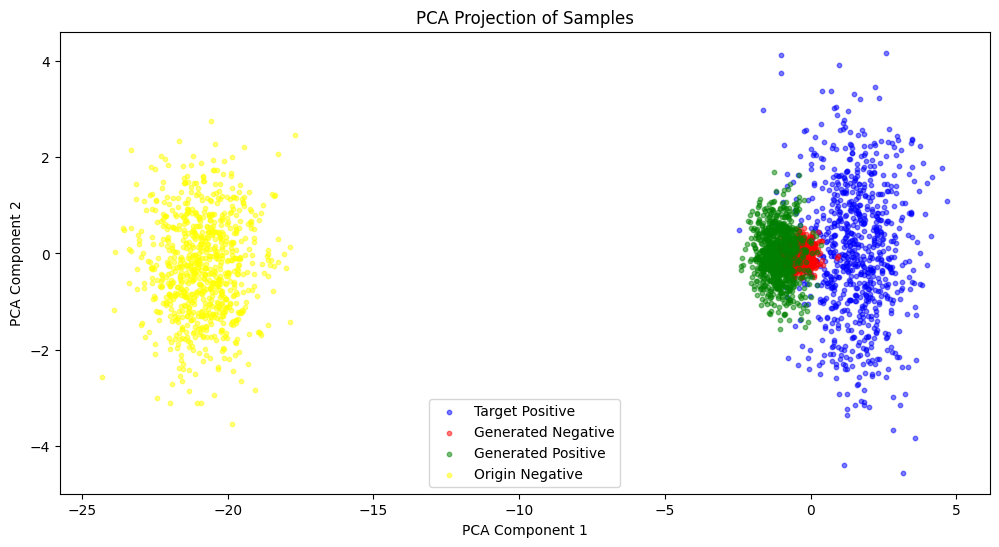

In [8]:
# 可视化样本分布（使用PCA）
visualize_distributions_PCA(all_positive.cpu().numpy(),all_negative.cpu().numpy(), generated_neg.cpu().numpy(), generated_pos.cpu().numpy())


/home/ckqsudo/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


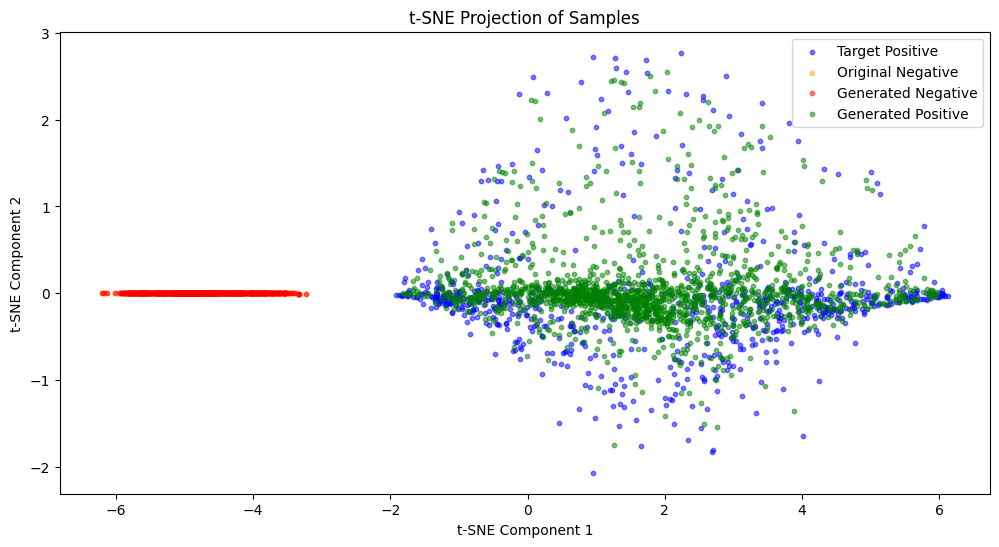

In [9]:

def visualize_distributions_tsne(target_positive,origin_neg, generated_neg, generated_pos):
    """
    使用t-SNE将高维数据降维到2维，并绘制分布图。
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    # 结合所有数据进行t-SNE
    combined = np.vstack((target_positive, origin_neg,generated_neg, generated_pos))
    tsne_results = tsne.fit_transform(combined)
    
    # 划分降维后的数据
    target_positive_tsne = tsne_results[:target_positive.shape[0]]
    origin_neg_tsne = tsne_results[target_positive.shape[0]:target_positive.shape[0]+origin_neg.shape[0]]
    generated_neg_tsne = tsne_results[target_positive.shape[0]:target_positive.shape[0]+generated_neg.shape[0]]
    generated_pos_tsne = tsne_results[target_positive.shape[0]+generated_neg.shape[0]:]
    
    plt.figure(figsize=(12, 6))
    
    # 绘制正样本
    plt.scatter(target_positive_tsne[:, 0], target_positive_tsne[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)
    # 绘制原始负样本
    plt.scatter(origin_neg_tsne[:, 0], origin_neg_tsne[:, 1],
                c='orange', label='Original Negative', alpha=0.5, s=10)
    
    # 绘制生成的负样本
    plt.scatter(generated_neg_tsne[:, 0], generated_neg_tsne[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)
    
    # 绘制生成的正样本
    plt.scatter(generated_pos_tsne[:, 0], generated_pos_tsne[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)
    
    plt.legend()
    plt.title('t-SNE Projection of Samples')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# 可视化样本分布（使用t-SNE）
visualize_distributions_tsne(all_positive.cpu().numpy(),all_negative.cpu().numpy(), generated_neg.cpu().numpy(), generated_pos.cpu().numpy())

In [ ]:

def compute_mean_covariance(tensor1, tensor2):
    mean1 = torch.mean(tensor1, dim=0)
    mean2 = torch.mean(tensor2, dim=0)
    cov1 = torch.cov(tensor1.T)
    cov2 = torch.cov(tensor2.T)
    mean_diff = torch.norm(mean1 - mean2, p=2).item()
    cov_diff = torch.norm(cov1 - cov2, p='fro').item()
    return mean_diff, cov_diff

def print_sample_values(generated_neg, generated_pos, all_positive, num_samples=5):
    print(f"\nSample Generated Negative Samples vs Target Positive Samples:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Generated Negative: {generated_neg[i].cpu().numpy()[:5]}...")
        print(f"Target Positive:    {all_positive[i].cpu().numpy()[:5]}...\n")
    
    print(f"Sample Generated Positive Samples vs Target Positive Samples:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Generated Positive: {generated_pos[i].cpu().numpy()[:5]}...")
        print(f"Target Positive:    {all_positive[i].cpu().numpy()[:5]}...\n")




In [ ]:


# 计算并打印均值和协方差差异
mean_diff_neg, cov_diff_neg = compute_mean_covariance(generated_neg, all_positive)
mean_diff_pos, cov_diff_pos = compute_mean_covariance(generated_pos, all_positive)
# 打印部分样本值
print_sample_values(generated_neg, generated_pos, all_positive, num_samples=5)

print("\nMean and Covariance Differences:")
print(f"Generated Negative vs Target Positive - Mean Diff: {mean_diff_neg:.6f}, Cov Diff: {cov_diff_neg:.6f}")
print(f"Generated Positive vs Target Positive - Mean Diff: {mean_diff_pos:.6f}, Cov Diff: {cov_diff_pos:.6f}")
